# 프로젝트: 뉴스기사 요약해보기
---
### 주요 라이브러리 버전

In [8]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from importlib.metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

from nltk.corpus import stopwords
nltk.download('stopwords')

3.6.5
2.6.0
1.3.3
1.2.0


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Step 1. 데이터 수집하기


In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
21603,Johnny Lever sold pens on streets before becom...,"Johnny Lever, who turned 61 today, used to sel..."
67583,Won't cooperate with graft probe: Philippine P...,Philippine President Rodrigo Duterte has said ...
33912,"Teen rapes minor in front of sister, his paren...",A 16-year-old boy allegedly raped his 13-year-...
23894,HC rejects Hyundai's plea on 'anti-competitive...,The Madras High Court has dismissed Hyundai Mo...
61725,Ranveer trolled over his pic's 'Losing my reli...,Ranveer Singh has been trolled for the caption...
69407,Child sexual abuse cases in Karnataka to be fa...,Karnataka High Court Chief Justice SK Mukherje...
96392,Air India staff's statements recorded in Shiv ...,The Delhi Police on Monday recorded the statem...
11570,Offended by talented predator charge: MJ Akbar...,Recording his statement in defamation suit fil...
41299,ISRO loses contact with satellite 2 days after...,ISRO on Sunday confirmed it has lost contact w...
50624,'Plastic road-maker' Rajagopalan Vasudevan win...,"Rajagopalan Vasudevan, dubbed 'plastic road-ma..."


---
## Step 2. 데이터 전처리하기 (추상적 요약)
---
### 중복 샘플과 NULL 값 존재하는 샘플 제거

In [13]:
## 중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [15]:
# Text 자체가 중복이 된 경우는 중복 샘플이므로 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [16]:
# 데이터프레임에 Null 값이 있는지 확인
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


In [17]:
# 데이터프레임에 Null 값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 텍스트 정규화와 불용어 제거
**데이터 정규화(text normalization)**  
기계 학습 전에 미리 같은 표현을 통일시켜 연산량을 줄이는 방법

In [18]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


**불용어(stopwords)**  
텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어

In [19]:
# NLTK에서 제공하는 불용어 리스트 : stopwords
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [20]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    # 텍스트 소문자화
    sentence = sentence.lower() 
    
    # html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text 
    
    # 특수 문자 제거 : 정규표현식    
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

# 데이터 전처리 함수 테스트
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'  
temp_summary = 'Great way to start (or finish) the day!!!'  

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [21]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = data['text'].apply(lambda x : preprocess_sentence(x))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object


In [23]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_summary = data['headlines'].apply(lambda x : preprocess_sentence(x, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

headlines 전처리 후 결과:  0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object


In [24]:
# 전처리 데이터 적용
data['text'] = clean_text
data['headlines'] = clean_summary

# 전처리 이후 빈 샘플 확인 및 제거

# 빈 값을 Null 값으로 변환 
data.replace('', np.nan, inplace=True)
# NULL 값 확인
data.isnull().sum()

# 빈 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [25]:
# clean 데이터 임시 저장
clean_data_path = os.getenv("HOME")+"/aiffel/news_summarization/data/ex12_clean.csv"
data.to_csv(clean_data_path, mode='w')

In [78]:
# clean data load
data = pd.read_csv(clean_data_path, nrows=100000)

### 샘플의 최대 길이 정하기
- 최소, 최대, 평균 길이 확인
- 길이 분포 시각화  
- Text 및 Summery 최대 길이를 정하고 해당 길이 이하 데이터 제외 처리

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


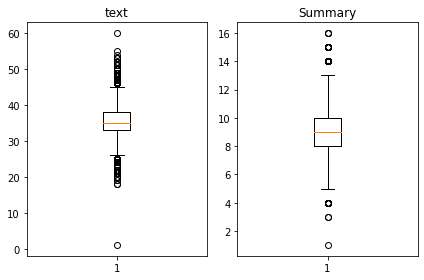

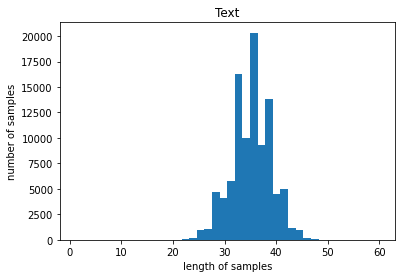

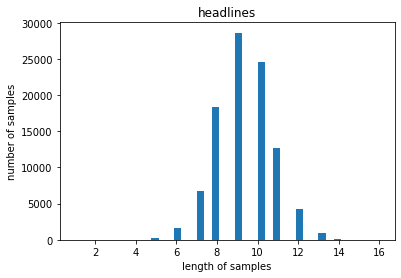

In [79]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에서부터 차례대로 
- 실제 텍스트와 요약의 길이 분포 그래프
- 실제 텍스트 샘플 길이별 개수 그래프
- 요약본 샘플 길이별 개수 그래프

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정하기

In [80]:
text_max_len = 40
summary_max_len = 10

# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [81]:
# data 데이터프레임을 임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외 처리
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len) &
         data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


### 시작 토큰과 종료 토큰 추가하기
- 시작토큰: 'sostoken'
- 종료토큰: 'eostoken'

In [82]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가

# decoder_input 컬럼 추가 - headlines 시작 토큰 추가 문장
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
# decoder_target 컬럼 추가 - Summary에 종료 토큰 추가 문장
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,Unnamed: 0,text,headlines,decoder_input,decoder_target
2,2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,9,congress candidate shafia zubair ramgarh assem...,cong wins ramgarh bypoll in rajasthan takes to...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,10,two minor cousins uttar pradesh gorakhpur alle...,up cousins fed human excreta for friendship wi...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


### 훈련 데이터 / 테스트 데이터 분리
- 분리코드 직접 구현하기

In [83]:
# 인코더의 입력, 디코더의 입력과 레이블 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

# encoder_input과 크기와 형태가 같고, 순서가 섞인 정수 시퀀스를 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[46050 14617 50237 ... 51510 28439 16522]


In [84]:
# 순서가 섞인 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [85]:
#8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2) # 테스트 데이터 갯수

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 변환  
**단어 집합(vocabulary)** 만들기
- 각 단어에 고유한 정수를 매핑하는 작업

In [86]:
# Keras의 토크나이저를 사용
src_tokenizer = Tokenizer()

# 입력된 데이터로부터 단어 집합 생성 >> src_tokenizer.word_index에 저장됨
src_tokenizer.fit_on_texts(encoder_input_train) 

#### 빈도수가 낮은 단어들은 훈련 데이터에서 제외 처리  
- 등장 빈도수(threshold)가 7회 미만인 단어들의 비중 확인

In [87]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61662
등장 빈도가 6번 이하인 희귀 단어의 수: 42385
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19277
단어 집합에서 희귀 단어의 비율: 68.73763419934481
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.191610048117637


- 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거  
- 단어 집합의 크기를 8,000으로 제한(num_words)하여 토크나이저를 정의
- 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다

In [88]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[66, 1551, 4612, 5, 998, 1602, 830, 5449, 392, 5208, 4392, 763, 398, 90, 76, 2224, 998, 3863, 115, 1432, 142, 1492, 348, 497, 1409, 442, 5208, 1901, 2224, 14346, 9300, 998, 16865], [79, 649, 2548, 6076, 6757, 2364, 3239, 3211, 50, 4157, 98, 3, 288, 3413, 4799, 17952, 2548, 3331, 2857, 15053, 640, 3211, 380, 508, 1178, 3332, 10030, 288, 14347, 615, 4], [1370, 152, 2026, 3671, 3637, 748, 5914, 450, 8099, 58, 315, 23, 28, 13, 1868, 142, 968, 8099, 8643, 10294, 11348, 168, 8848, 15920, 5020, 13164, 4613, 723, 5755, 212, 1105, 2333, 8099, 170, 451]]


#### Summary 데이터에 대해서도 동일한 작업을 수행

In [89]:

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27273
등장 빈도가 4번 이하인 희귀 단어의 수: 17125
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10148
단어 집합에서 희귀 단어의 비율: 62.79103875627911
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.0346474236289085


In [90]:
tar_vocab = 10100
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 64, 433, 14, 1669, 52, 1897, 4, 2956], [1, 9, 515, 5412, 3332, 7, 2060, 3045], [1, 400, 6, 1646, 1927, 3975, 4898, 1020, 204], [1, 999, 104, 2153, 4, 23, 3224, 389, 1526, 452, 57], [1, 14, 143, 2957, 5, 102, 460, 102, 107]]
target
decoder  [[64, 433, 14, 1669, 52, 1897, 4, 2956, 2], [9, 515, 5412, 3332, 7, 2060, 3045, 2], [400, 6, 1646, 1927, 3975, 4898, 1020, 204, 2], [999, 104, 2153, 4, 23, 3224, 389, 1526, 452, 57, 2], [14, 143, 2957, 5, 102, 460, 102, 107, 2]]


####  패딩 하기로 넘어가기 전에 한 가지 점검
빈도수가 낮은 단어만으로 구성되었던 샘플들이 이제 빈(empty) 샘플이 되었을 가능성 
- Summary의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높다
- 시작/종료 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높아 단어 집합 제한에도 삭제되지 않음
- 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아  길이가 0이 된 요약문의 실제 길이는 1

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하기

In [91]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### 패딩하기
서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 작업  
- 아까 정해두었던 최대 길이로 패딩
- 최대 길이보다 짧은 데이터들은 뒤의 공간에(post) 숫자 0을 넣어 최대 길이로 길이를 맞춘다

In [92]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

---
## 모델 설계하기
---
### 함수형 API를 이용해서 인코더를 설계 : LSTM

In [93]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터의 차원
hidden_size = 256 # LSTM 수용력(capacity) 설정

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

**embedding_dim** : 임베딩 벡터 차원  
**hidden_size** : LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
- LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수
- 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다

인코더의 LSTM은 총 3개의 층으로 구성
- hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면
- 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있다

LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용 가능   

**일반적인 dropout**  
- 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법  

**recurrent dropout**  
- dropout을 레이어가 아닌 time step마다 해주는 방식
- ime step의 입력을 랜덤으로 생략해 준다
- 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다  

**Variational Dropout**  
dropout과 recurrent dropout을 모두 사용한 것  
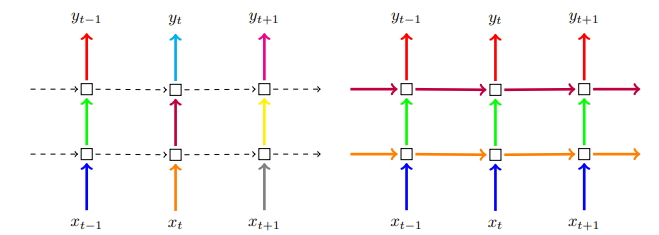

---
### 디코더 설계

In [94]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다  
- LSTM의 입력을 정의할 때 initial_state의 인자값 : 인코더의 hidden state와 cell state의 값

#### 디코더의 출력층 설계

In [95]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

디코더의 출력층 - 다중 클래스 분류 문제를 풀어야 한다
- Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택
- Dense의 인자 : tar_vocab
- 활성화 함수 : 소프트맥스 함수 사용

#### 지금까지 기본적인 seq2seq 설계
- 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용

디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법 >>> 어텐션 메커니즘

---
### 어텐션 메커니즘
TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하기  
- 어텐션 함수 : Bahdanau 스타일의 어텐션

In [96]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

---
## 모델 훈련하기
---


In [74]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 59s 86ms/step - loss: 6.4016 - val_loss: 6.0416
Epoch 2/50
232/232 [==============================] - 19s 82ms/step - loss: 5.8768 - val_loss: 5.6423
Epoch 3/50
232/232 [==============================] - 19s 84ms/step - loss: 5.5383 - val_loss: 5.3855
Epoch 4/50
232/232 [==============================] - 20s 86ms/step - loss: 5.2511 - val_loss: 5.1634
Epoch 5/50
232/232 [==============================] - 20s 88ms/step - loss: 5.0027 - val_loss: 4.9908
Epoch 6/50
232/232 [==============================] - 20s 88ms/step - loss: 4.7921 - val_loss: 4.8526
Epoch 7/50
232/232 [==============================] - 20s 86ms/step - loss: 4.6121 - val_loss: 4.7500
Epoch 8/50
232/232 [==============================] - 20s 86ms/step - loss: 4.4553 - val_loss: 4.6763
Epoch 9/50
232/232 [==============================] - 20s 87ms/step - loss: 4.3170 - val_loss: 4.6076
Epoch 10/50
232/232 [==============================] - 20s 87ms/step - loss: 4.191

조기종료(EarlyStopping) 설정: 특정 조건 충족 시 훈련 종료  
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)  
- monitor : val_loss (검증 데이터 손실이 감소하지 않고 증가하는 현상 관찰)
- patience : 2 (관찰 조건을 2회 발견 시 종료)

조기 종료 설정시 훈련이 종료되었을 때 성능이 최고인 상황이 아닐 수 있다  

#### 훈련 데이터 손실과 검증 데이터 손실의 감소 과정 시각화

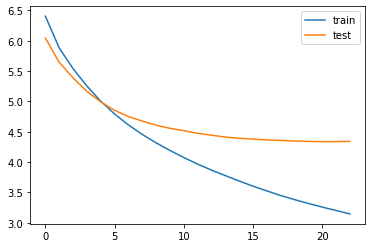

In [97]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

---
## 인퍼런스 모델  구현
---
정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원을 위해 단어 사전 준비

In [98]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

**seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다**  

훈련 단계  
- 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교 가능
- 인코더와 디코더를 엮은 통짜 모델 하나만 준비

정답 문장이 없는 인퍼런스 단계  
- 만들어야 할 문장의 길이 만큼 디코더가 반복 구조로 동작해야 한다
- 인퍼런스를 위한 별도 모델 설계 필요
- 인코더 모델과 디코더 모델을 분리해서 설계

In [100]:
#-----------------------------------------
# 인코더 설계
#-----------------------------------------
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#-----------------------------------------
# 어텐션 메커니즘을 사용하는 출력층 설계
#-----------------------------------------
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [101]:
#------------------------------------------------
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
#------------------------------------------------
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

---
## 모델 테스트
---
정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인  
주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 구현  
- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외
- Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

### 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수

In [102]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [103]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : case huawei cfo meng wanzhou arrested canada us request fraud banks relationship huawei unofficial subsidiary huawei allegedly used business iran breaching us sanctions meng allegedly told banks separate companies banks know clearing transactions involving iran 
실제 요약 : why was huawei cfo arrested in canada at us request 
예측 요약 :  vishal dung ardern flak reduces melting saira gavaskar esha


원문 : chinese phone maker mobile said plans invest crore start production india talking foxconn setting manufacturing facility noida near delhi company business head rajeev tiwari said company also cater countries like nepal bangladesh sri lanka vietnam philippines tiwari added 
실제 요약 : mobile to invest cr to start production in india 
예측 요약 :  mou colombia worry solo abvp wrestler kurdish chand navi


원문 : prince kumar son delhi transport corporation bus driver topped cbse class exams science stream across delhi government schools score delhi education minister manish sisodia took twitter cong

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보이네요.    
심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요.     
워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!  
물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 하네요.  

**성능을 개선 방안*  
- seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법
- 빔 서치(beam search)
- 사전 훈련된 워드 임베딩(pre-trained word embedding)
- 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)

---
## 추출적 요약 해보기
---
**패키지 Summa**
추출적 요약을 위한 모듈인 summarize를 제공  

#### 영화 매트릭스 시놉시스를 요약하기
- summarize 사용법을 익혀볼까요?

### 패키지 설치
```
$ pip list | grep summa
```
### 데이터 다운로드  

In [122]:
import requests
from summa.summarizer import summarize
# text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
text_list = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

text = text_list['text'][0]
print(text[:1500])

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


### summarize 사용하기
Summa의 summarize()의 인자  
- text (str) : 요약할 테스트.
- ratio (float, optional) : 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) : 출력에 포함할 단어 수.
    만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) : True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다.  
그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다  

In [135]:
print('Summary:')
print(summarize(text, ratio=0.5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [136]:
print('Summary:')
print(summarize(text, ratio=0.5, split=True))

Summary:
["upGrad's Online Power Learning has powered 3 lakh+ careers."]


In [131]:
print('Summary:')
print(summarize(text, words=5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.
